### **Dataset from huggingface**

In [3]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Check if GPUs are available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid full memory allocation
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print(f"Error setting up GPU memory growth: {e}")
else:
    print("No GPU detected. Using CPU.")


GPUs detected: ['/physical_device:GPU:0']


In [3]:
!pip install -U datasets

### **Dataset 1 : trashnet_enhanced** (19.9k)

In [4]:
# from datasets import load_dataset
# data1 = load_dataset("edwinpalegre/trashnet_enhanced")

### **Dataset 2 : small trashnet** ( 2.53k)

In [5]:
# from datasets import load_dataset
# data2 = load_dataset("kuchidareo/small_trashnet")

### **Datset 3 : trashnet** (5.5k)

In [6]:
# from datasets import load_dataset
# data3 = load_dataset("garythung/trashnet")

## **Importing Libraries**

In [83]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from collections import Counter

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [71]:
from tensorflow import keras
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array# type: ignore
from tensorflow.keras.applications import ResNet50,VGG16 # type: ignore
from tensorflow.keras.applications.resnet50 import preprocess_input # type: ignore
from tensorflow.keras.applications.vgg16 import preprocess_input # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore

##Setting up Directory to save model data

In [10]:
os.makedirs('test_dir', exist_ok=True)

In [11]:
project_name = 'Waste_Classification'

model_names = [
    'Custom_CNN_From_Scratch',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

base_dir = '/content/'

project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/Waste_Classification


## **Analysis of Data**

## **Dataset : small_trashnet**

In [12]:
from datasets import load_dataset
dataset = load_dataset("kuchidareo/small_trashnet")

In [13]:
label_mapping = {
    0: 'cardboard',
    1: 'glass',
    2: 'metal',
    3: 'paper',
    4: 'plastic',
    5: 'trash'
}

In [ ]:
print("--------------------------")
print("Small Trashnet Dataset")
print("--------------------------\n")

all_dimensions_set = set()

label_image_count = {}

total_images = 0

for item in dataset['train']:
    label = item['label']
    image = item['image']

    if label not in label_image_count:
        label_image_count[label] = 0
    label_image_count[label] += 1
    total_images += 1

    if hasattr(image, 'size') and hasattr(image, 'getbands'):
        width, height = image.size
        channels = len(image.getbands())
        all_dimensions_set.add((width, height, channels))
    else:
        print(f"Warning: Skipping item with non-image 'image' field type: {type(image)}")


for label, count in label_image_count.items():
    print(f"{label} folder contains {count} images.")

print(f"\nTotal images in the dataset: {total_images}")

if len(all_dimensions_set) == 1:
    if all_dimensions_set:
        width, height, channels = all_dimensions_set.pop()
        print(f"All images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
    else:
        print("No valid images found to determine dimensions.")
else:
    print("The images in the dataset have different dimensions or color channels.")

--------------------------
Small Trashnet Dataset
--------------------------

0 folder contains 403 images.
1 folder contains 501 images.
2 folder contains 410 images.
3 folder contains 594 images.
4 folder contains 482 images.
5 folder contains 137 images.

Total images in the dataset: 2527
All images in the dataset have the same dimensions: 512x384 with 3 color channels.


## **Images of Each Category**

In [15]:
label_mapping = {
    0: 'cardboard',
    1: 'glass',
    2: 'metal',
    3: 'paper',
    4: 'plastic',
    5: 'trash'
}

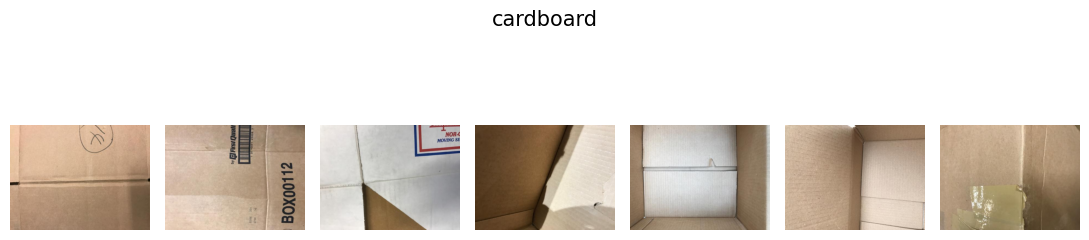

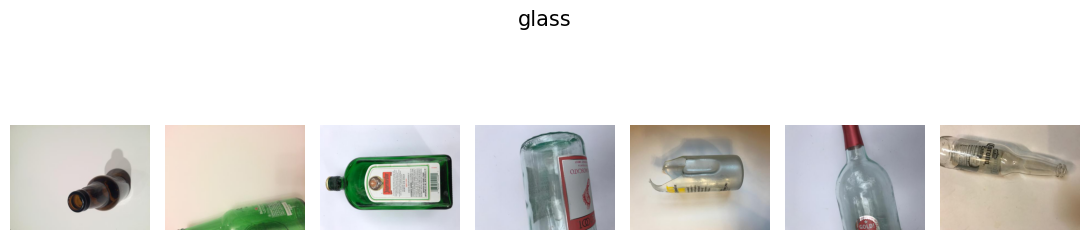

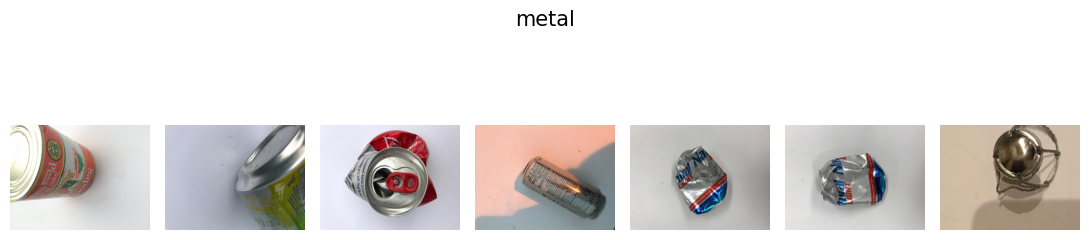

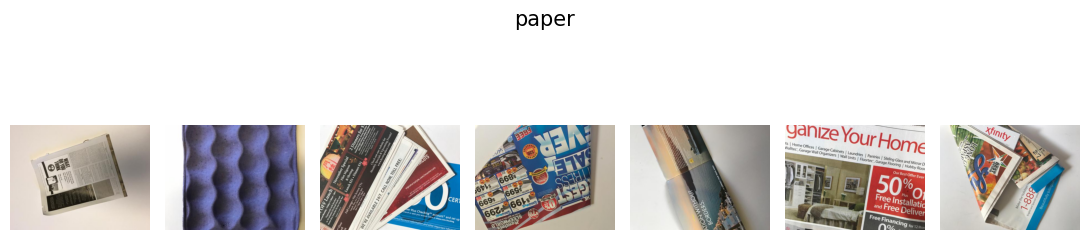

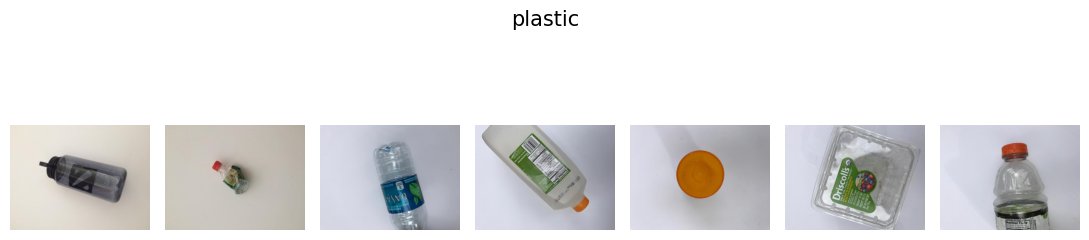

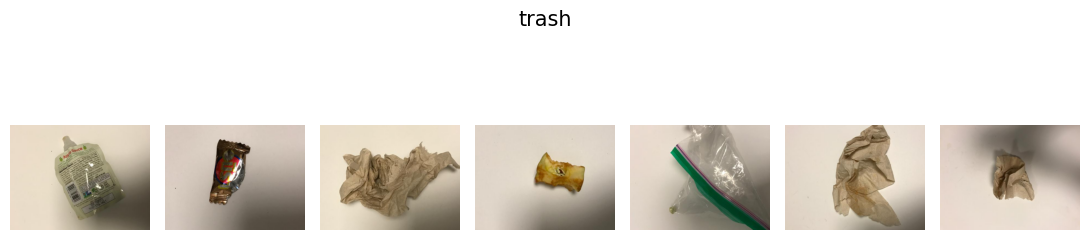

In [17]:
garbage_types = sorted(set([item['label'] for item in dataset['train']]))

for garbage_type in garbage_types:
    filtered_dataset = [item for item in dataset['train'] if item['label'] == garbage_type]

    images = []
    for i, item in enumerate(filtered_dataset):
        if i >= 7:
            break
        images.append(item['image'])

    if not images:
        continue

    fig, axs = plt.subplots(1, len(images), figsize=(11, 3))

    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')

    fig.suptitle(f"{label_mapping[garbage_type]}", fontsize=15, y=1.0)
    plt.tight_layout()
    plt.show()

In [18]:
labels = [label_mapping[example['label']] for example in dataset['train']]

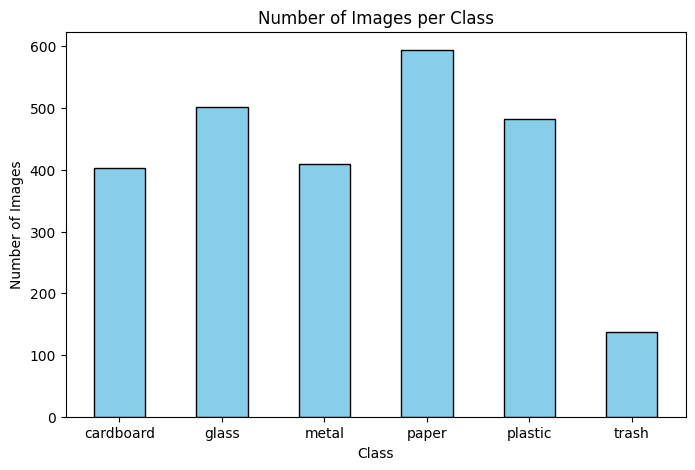

In [19]:
class_counts = Counter(labels)
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(),
        class_counts.values(),
        color='skyblue',
        edgecolor='k',
        width=0.5)

plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class")
plt.xticks(rotation=0)
plt.show()

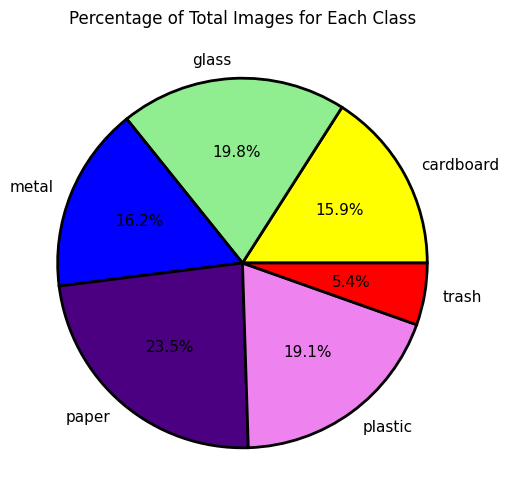

In [20]:
textprops = {'fontsize':11 , }
wedgeprops = {'linewidth':2 , 'width':1,'edgecolor':'k'}

plt.figure(figsize=(6,6))
plt.pie(class_counts.values(),
        labels=class_counts.keys(),
        autopct='%1.1f%%',
        colors=['yellow','lightgreen','blue','indigo','violet','red'],
        textprops=textprops,
        wedgeprops=wedgeprops
        )
plt.title("Percentage of Total Images for Each Class")
plt.show()

## **Data Splitting**

In [22]:
dataset.column_names

{'train': ['image', 'label']}

In [23]:
data = []

for item in dataset['train']:
    label_num = item['label']
    label = label_mapping[label_num]
    data.append((item['image'], label))

df = pd.DataFrame(data, columns=['image', 'label'])

In [24]:
print(pd.DataFrame(df.head()))

                                               image      label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...  cardboard


In [25]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2527 entries, 0 to 2526
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   2527 non-null   object
 1   label   2527 non-null   object
dtypes: object(2)
memory usage: 39.6+ KB
None


In [26]:
def extract_labels(example):
    return {'labels': example['label']}

dataset = dataset.map(extract_labels, remove_columns=['label'])

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 2021
Number of images in the validation set: 506


In [27]:
overall_distribution = df['label'].value_counts(normalize=True) * 100

train_distribution = train_df['label'].value_counts(normalize=True) * 100

val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


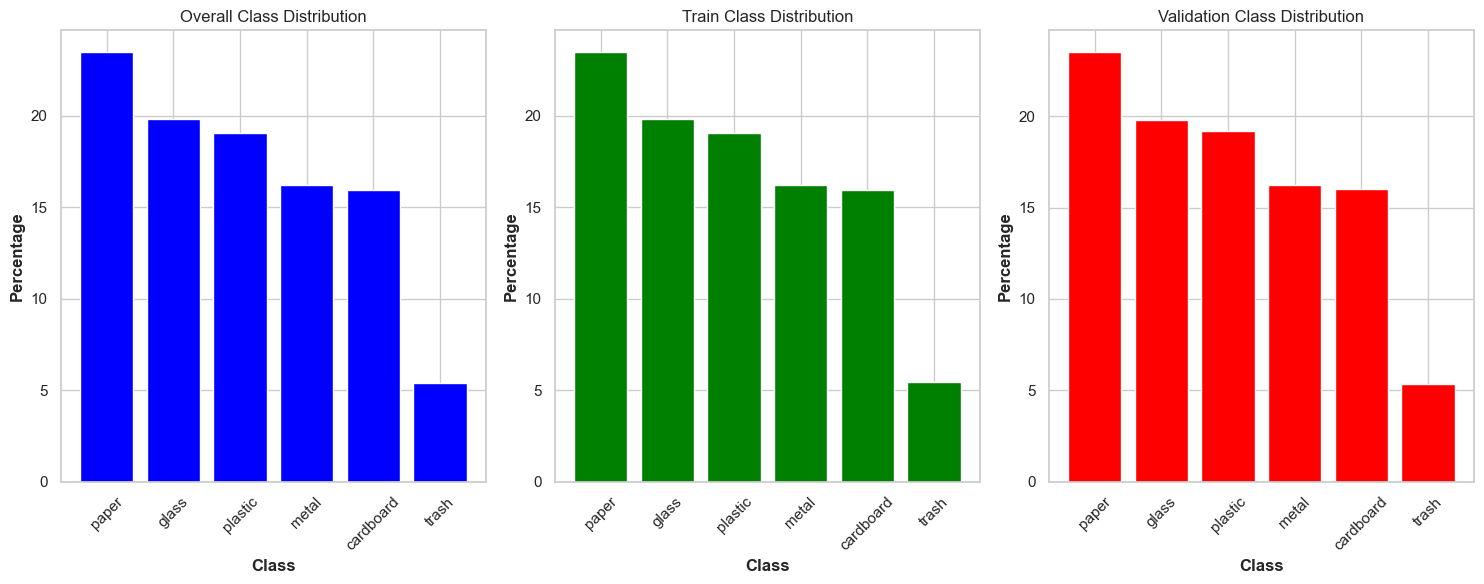

In [28]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with three subplots
fig, axes = plt.subplots(1,3, figsize=(15,6))

# Plot for overall distribution
axes[0].bar(overall_distribution.index, overall_distribution.values, color='blue')
axes[0].set_title("Overall Class Distribution")
axes[0].set_xlabel("Class", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Percentage", fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Plot for train distribution
axes[1].bar(train_distribution.index, train_distribution.values, color='green')
axes[1].set_title("Train Class Distribution")
axes[1].set_xlabel("Class",fontsize=12, fontweight='bold')
axes[1].set_ylabel("Percentage",fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

# Plot for validation distribution
axes[2].bar(val_distribution.index, val_distribution.values, color='red')
axes[2].set_title("Validation Class Distribution")
axes[2].set_xlabel("Class",fontsize=12, fontweight='bold')
axes[2].set_ylabel("Percentage",fontsize=12, fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Data Augmentation & Rescaling

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

val_datagen = ImageDataGenerator(rescale=1./255)

## Generating Batches of Image

In [30]:
import os

output_dir = "image"
os.makedirs(output_dir, exist_ok=True)

def save_image_and_get_path(row):
    img_path = os.path.join(output_dir, f"{row.name}.jpg")
    if isinstance(row["image"], str):
        return row["image"]
    elif hasattr(row["image"], "save"):
        row["image"].save(img_path)
        return img_path
    else:
        return None

train_df["filepath"] = train_df.apply(save_image_and_get_path, axis=1)
val_df["filepath"] = val_df.apply(save_image_and_get_path, axis=1)

train_df = train_df.dropna(subset=["filepath"])
val_df = val_df.dropna(subset=["filepath"])

train_df["filepath"] = train_df["filepath"].astype(str)
val_df["filepath"] = val_df["filepath"].astype(str)

x_col="filepath"

print(train_df["filepath"].head())
print(type(train_df["filepath"].iloc[0]))

2395    image\2395.jpg
567      image\567.jpg
741      image\741.jpg
1720    image\1720.jpg
1066    image\1066.jpg
Name: filepath, dtype: object
<class 'str'>


In [31]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                     # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [32]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [33]:
# Get number of batches per epoch
num_batches = len(train_generator)

# Get total number of augmented images per epoch
total_augmented_images = num_batches * train_generator.batch_size

print(f"Total augmented images per epoch: {total_augmented_images}")

Total augmented images per epoch: 2048


In [34]:
img_width, img_height = 48, 48
num_classes = 6

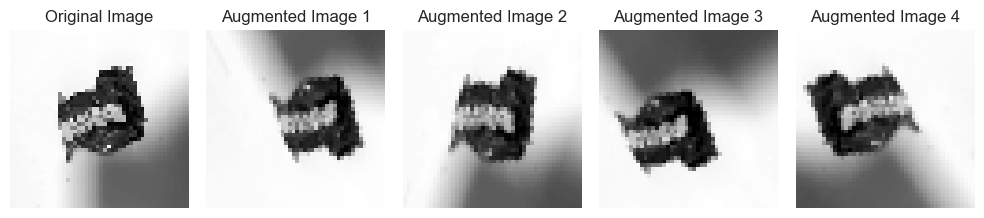

In [36]:
# Path to your specific image
image_path = 'image/2516.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = train_datagen.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Addressing Dataset Imbalances

In [37]:
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [38]:
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])
weights

array([3.06212121, 0.83998337, 0.70912281, 1.02693089, 0.87489177,
       1.04606625])

In [39]:
# assigns different importance levels to different classes
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

## Model From Scratch

In [40]:
def residual_block(X, kernel_size, filters, reduce=False, stride=2):

    F1, F2, F3 = filters

    X_shortcut = X

    if reduce:
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    else:
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

    X = Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [41]:
def model_scratch(input_shape, classes):

    X_input = Input(input_shape)

    # Block 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Block 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Block 3
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Block 4
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Block 5
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    X = GlobalAveragePooling2D()(X)

    X = Dense(classes, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [42]:
def Modified_model_scratch(input_shape, classes):

    X_input = Input(input_shape)

    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])


    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    X = GlobalAveragePooling2D()(X)

    X = Dropout(0.5)(X)

    X = Dense(classes, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='Modified_Model')

    return model

In [43]:
input_shape = (384, 384, 3)
num_classes = 6

modified_model = Modified_model_scratch(input_shape=input_shape, classes=num_classes)

In [44]:
modified_model.summary()

Model: "Modified_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 189, 189, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 189, 189, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

In [45]:
modified_model.compile(optimizer='adam', #0.001
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [46]:
# File path for the model checkpoint
cnn_path = '/content/Waste_Classification/Custom_CNN_From_Scratch'
name = 'ModelFromScratch.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/Waste_Classification/Custom_CNN_From_Scratch\\ModelFromScratch.keras'

In [48]:
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=15,
                              min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss',
                               mode='min',
                               patience=50,
                               restore_best_weights=True,
                               verbose=1)

In [49]:
print("Assigned Class Weights:")
class_weights

Assigned Class Weights:


{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

In [ ]:
num_epochs = 5

history = modified_model.fit(train_generator,
                            steps_per_epoch=len(train_generator),
                            epochs=num_epochs,
                            validation_data=val_generator,
                            validation_steps=len(val_generator),
                            class_weight=class_weights,
                            callbacks=[checkpoint,reduce_lr, early_stopping],
                            verbose=1)

Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'Modified_Model/batch_normalization_20/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\paras\anaconda3\envs\mytf\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\paras\anaconda3\envs\mytf\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\paras\anaconda3\envs\mytf\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\paras\anaconda3\envs\mytf\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\paras\anaconda3\envs\mytf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\paras\AppData\Local\Temp\ipykernel_27152\1951740499.py", line 3, in <module>
      history = modified_model.fit(train_generator,
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\paras\anaconda3\envs\mytf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 634, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'Modified_Model/batch_normalization_20/FusedBatchNormV3'
OOM when allocating tensor with shape[32,47,47,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Modified_Model/batch_normalization_20/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13174]

In [53]:
def plot_learning_curves(history, start_epoch=5):
    df = pd.DataFrame(history.history)
    df = df.iloc[start_epoch-1:]
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='green', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='red', linestyle='--', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Evolution')

    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='darkblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='red', linestyle='--', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

### plot curves

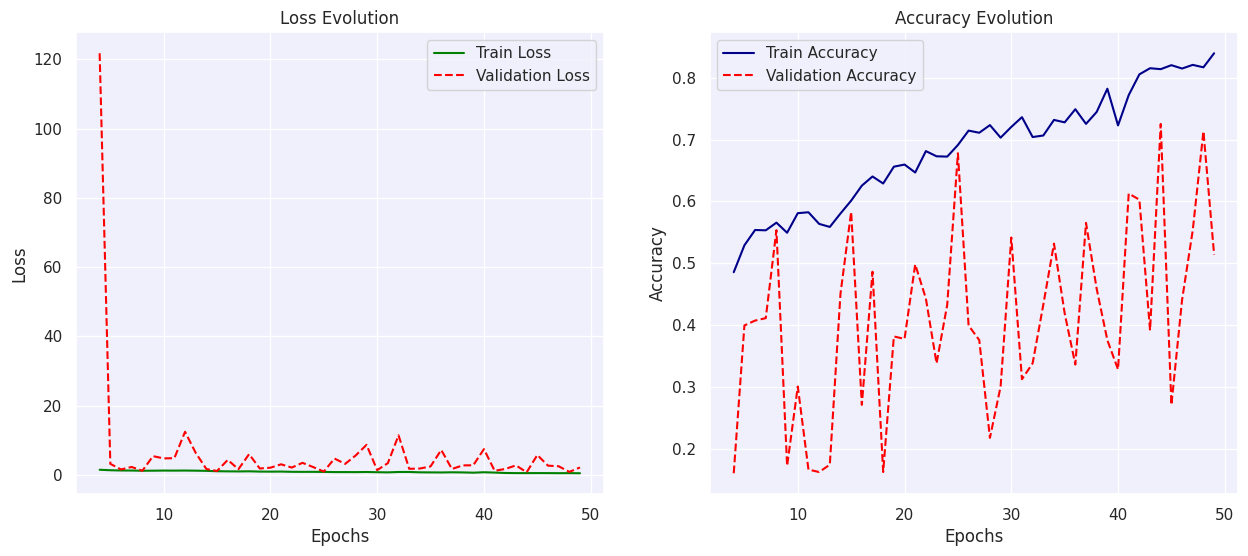

In [ ]:
plot_learning_curves(history)

### Evaluate model performance

In [54]:
def evaluate_model_performance(model, val_generator, class_labels):

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 489ms/step
              precision    recall  f1-score   support

   cardboard       0.73      0.98      0.84        81
       glass       0.64      0.65      0.64       100
       metal       0.71      0.61      0.66        82
       paper       0.80      0.87      0.83       119
     plastic       0.80      0.57      0.66        97
       trash       0.52      0.56      0.54        27

    accuracy                           0.73       506
   macro avg       0.70      0.70      0.69       506
weighted avg       0.73      0.73      0.72       506





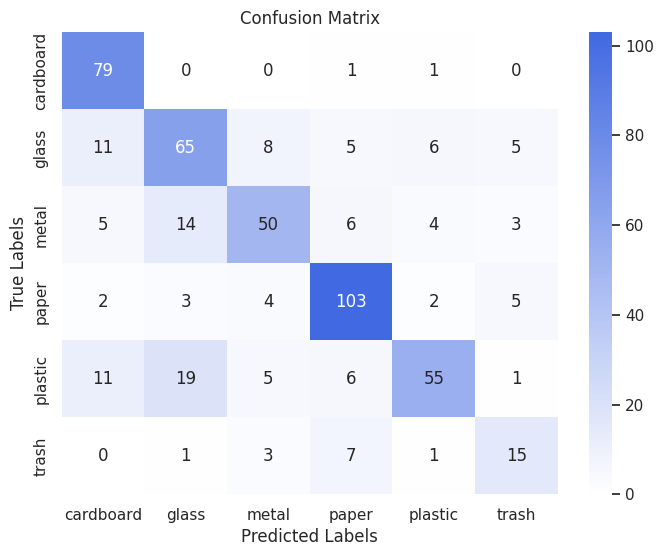

In [ ]:
evaluate_model_performance(modified_model, val_generator, class_labels)

## Testing Model

In [ ]:
model = keras.models.load_model("/content/Waste_Classification/Custom_CNN_From_Scratch/ModelFromScratch.keras")

In [ ]:
test_loss, test_accuracy = modified_model.evaluate(val_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.7416 - loss: 0.6599
Test Loss: 0.7306
Test Accuracy: 0.7253


## AUC ROC Plot for each class

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 216ms/step


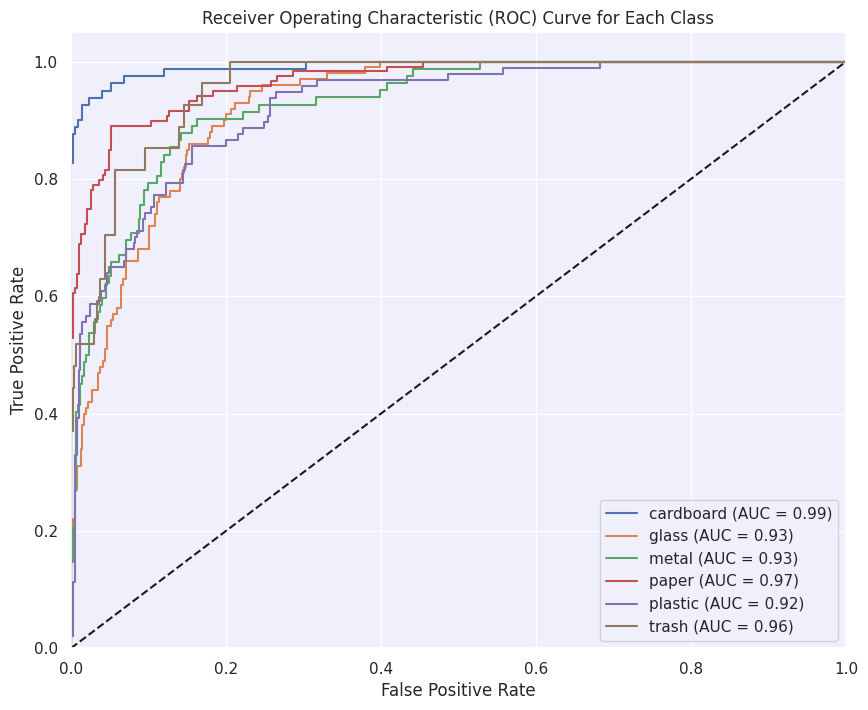

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

y_true = val_generator.classes
y_pred_probs = modified_model.predict(val_generator)

# Binarize the true labels for multi-class ROC calculation
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{label_mapping[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# ResNet50 with Transfer Learning

## Loading ResNet50 with pretrained weights

In [55]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

In [56]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 390, 390, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 192, 192, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [57]:
len(base_model.layers)

175

In [58]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


In [59]:
# Freeze the layers up to conv4_block6_out
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [62]:
plot_model(transfer_resnet50_model, show_shapes=False, show_layer_names=False, dpi=72)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [63]:
transfer_resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 390, 390, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 192, 192, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Applying ResNet50-specific Image Preprocessing

In [64]:
train_datagen = ImageDataGenerator(
    rotation_range=60,                 
    width_shift_range=0.15,            
    height_shift_range=0.15,           
    zoom_range=0.20,                 
    horizontal_flip=True,             
    vertical_flip=True,                 
    shear_range=0.05,                   
    brightness_range=[0.9, 1.1],        
    channel_shift_range=10,            
    fill_mode='nearest',                 
    preprocessing_function=preprocess_input  
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 

In [65]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                 
    x_col="filepath",                   
    y_col="label",                     
    target_size=(384, 384),            
    batch_size=32,                     
    class_mode='categorical',           
    seed=42,                            
    shuffle=False                      
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                   
    x_col="filepath",                  
    y_col="label",                      
    target_size=(384, 384),              
    batch_size=32,                      
    class_mode='categorical',          
    seed=42,                            
    shuffle=False                      
)


Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [67]:
cnn_path = 'Waste_Classification/ResNet50_Transfer_Learning'
name = 'ResNet50TransferLearning.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'Waste_Classification/ResNet50_Transfer_Learning\\ResNet50TransferLearning.keras'

## Fine-tuning the Transfer Learning ResNet50 Model

In [69]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, patience=5, 
                              min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', patience=15, 
                               restore_best_weights=True,
                               verbose=1)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [70]:
num_epochs = 30

history = transfer_resnet50_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping,checkpoint])


Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 1.0109 - accuracy: 0.6408
Epoch 1: val_loss improved from inf to 0.49511, saving model to Waste_Classification/ResNet50_Transfer_Learning\ResNet50TransferLearning.keras
64/64 [==============================] - 38s 557ms/step - loss: 1.0109 - accuracy: 0.6408 - val_loss: 0.4951 - val_accuracy: 0.8281 - lr: 1.0000e-04
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.4153 - accuracy: 0.8595
Epoch 2: val_loss improved from 0.49511 to 0.34344, saving model to Waste_Classification/ResNet50_Transfer_Learning\ResNet50TransferLearning.keras
64/64 [==============================] - 37s 576ms/step - loss: 0.4153 - accuracy: 0.8595 - val_loss: 0.3434 - val_accuracy: 0.8814 - lr: 1.0000e-04
Epoch 3/30
63/64 [============================>.] - ETA: 0s - loss: 0.2466 - accuracy: 0.9172
Epoch 3: val_loss did not improve from 0.34344
64/64 [==============================] - 36s 559ms/step - loss: 0.2470 - accuracy: 

In [74]:
test_loss, test_accuracy = transfer_resnet50_model.evaluate(val_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

16/16 [==============================] - 4s 200ms/step - loss: 0.1877 - accuracy: 0.9387
Test Loss: 0.1877
Test Accuracy: 0.9387


## Visualizing the Learning Curves

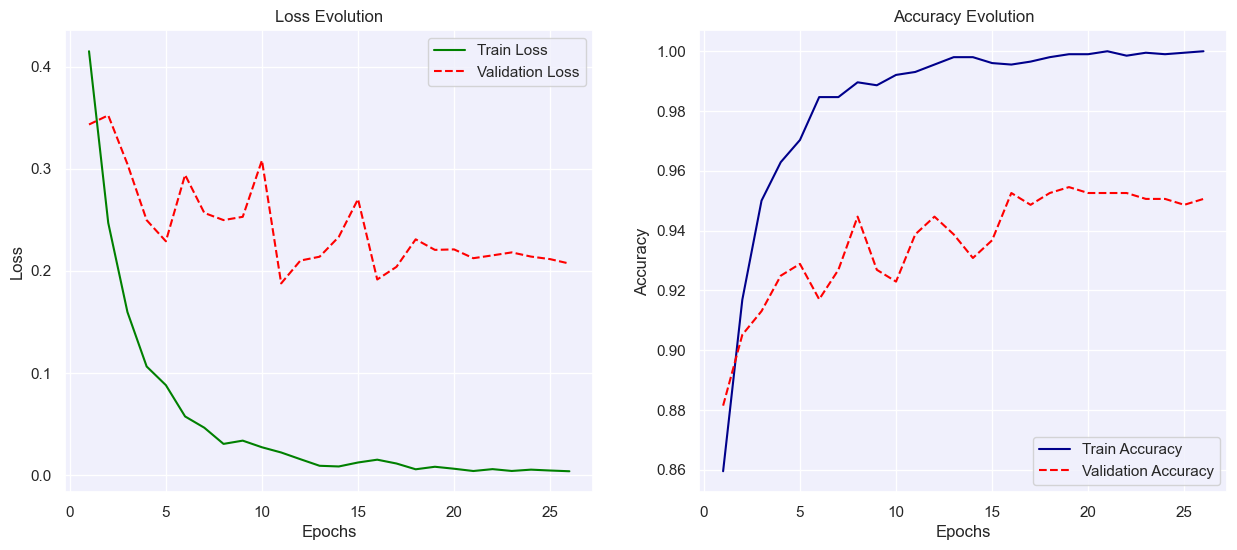

In [72]:
plot_learning_curves(history, start_epoch=2)

## Performance Metrics Assessment

16/16 [==============================] - 4s 222ms/step
              precision    recall  f1-score   support

   cardboard       0.98      0.98      0.98        81
       glass       0.92      0.95      0.94       100
       metal       0.94      0.90      0.92        82
       paper       0.95      0.97      0.96       119
     plastic       0.95      0.93      0.94        97
       trash       0.81      0.81      0.81        27

    accuracy                           0.94       506
   macro avg       0.92      0.92      0.92       506
weighted avg       0.94      0.94      0.94       506





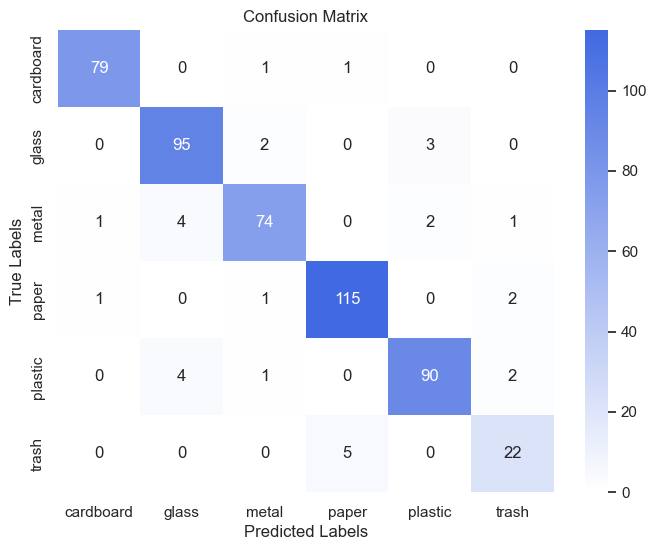

In [73]:
evaluate_model_performance(transfer_resnet50_model, val_generator, class_labels)

In [80]:
y_true = val_generator.classes
y_pred_probs = transfer_resnet50_model.predict(val_generator)

16/16 [==============================] - 3s 225ms/step


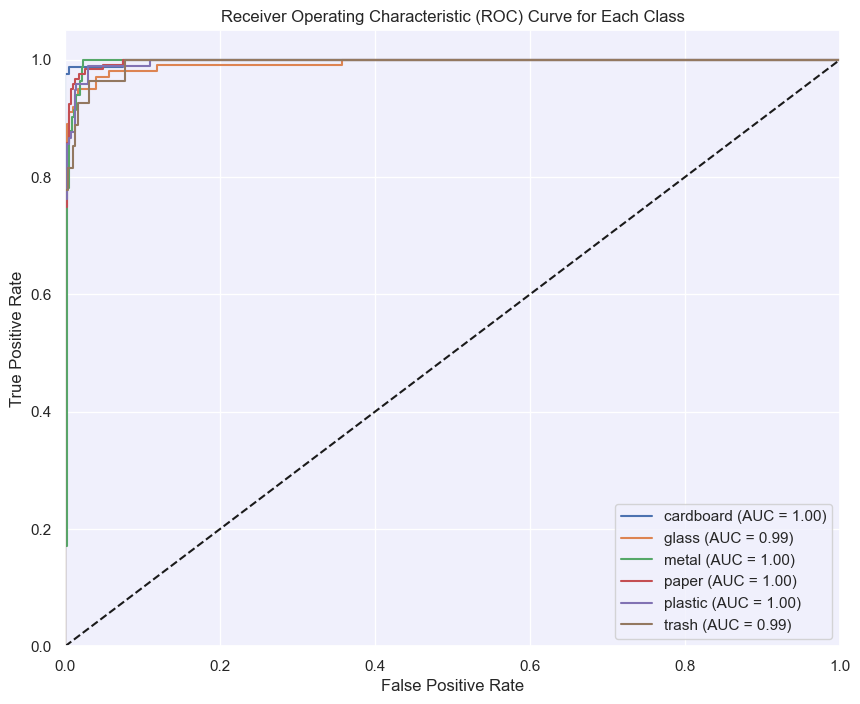

In [85]:
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{label_mapping[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()